# Notes
1. We use SARIMAX model to predict spot price (we have to ideas for now):
   1. Use inter_gen and demand to predict spot price
   2. Predict demand then use the predicted demand and inter_gen to predict spot price (**More practical as we don't know future demand in real life**)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf

from tsa_utils import *

import warnings
warnings.filterwarnings("ignore")

from time import time
from datetime import timedelta

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

## 1) Load dataset

In [2]:
data = pd.read_csv("../../data/all.csv")
data.tail(3)

,time,spot_price_nsw,spot_price_sa,spot_price_tas,spot_price_vic,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_nsw,demand_sa,demand_tas,demand_vic,period
63454,2021-08-14 23:00:00,55.64,77.76,7.63,32.26,7.69,42.04,160.30,215.20,8194,1614,1207,5204,47
63455,2021-08-14 23:30:00,52.25,76.47,7.52,25.10,8.35,38.04,167.00,226.95,8022,1573,1163,5268,48
63456,2021-08-15 00:00:00,48.69,83.68,23.87,8.73,8.07,47.47,156.92,251.75,7867,1680,1139,5244,1


## 2) Join dataset and some feature engineering

In [37]:
df = data.copy(deep=False).set_index('time').asfreq('30T')
df = data.copy(deep=False).set_index('time')
df.index = df.index.astype('datetime64[ns]')
df = df.asfreq('30T')

df = df[df.index <= "2021-08-11 23:30:00"]
df_train = df[df.index <= "2020-12-31 23:30:00"]
df_cv = df[(df.index >= "2021-01-01 00:00:00") & (df.index <= "2021-06-30 23:30:00")]
df_test = df[(df.index >= "2021-07-01 00:00:00") & (df.index <= "2021-08-11 23:30:00")]

idx_cv_start = df.reset_index()[df.index == df_cv.index[0]].index[0] # index of df(full) where cv start
idx_test_start = df.reset_index()[df.index == df_test.index[0]].index[0] # index of df(full) where test start

df.tail(3)

,spot_price_nsw,spot_price_sa,spot_price_tas,spot_price_vic,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_nsw,demand_sa,demand_tas,demand_vic,period
time,,,,,,,,,,,,,
2021-08-11 22:30:00,55.27,52.01,20.91,54.29,156.25,240.22,166.32,330.72,8002,1735,1338,5450,46
2021-08-11 23:00:00,51.44,48.29,13.68,49.25,150.55,228.38,165.11,320.81,7849,1654,1308,5269,47
2021-08-11 23:30:00,54.42,49.82,11.29,51.37,146.67,242.53,167.19,296.36,7795,1571,1259,5332,48


In [5]:
# Check if spot price is stationary
compute_adfuller_test(df_train.spot_price_vic)

Results of Dickey-Fuller Test:
Test Statistic                  -26.21
p-value                           0.00
#Lags Used                       48.00
Number of Observations Used   52559.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


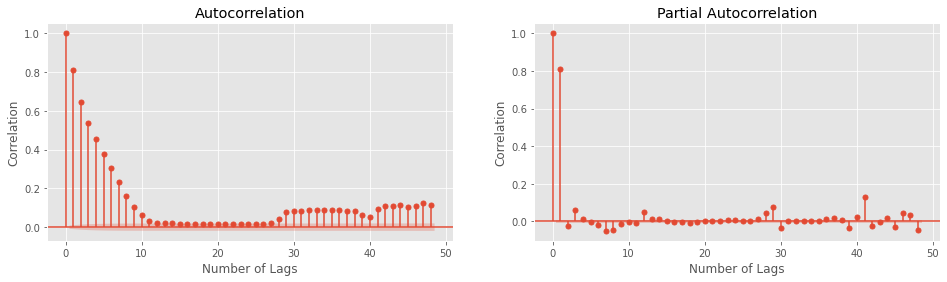

In [6]:
# Plot time series correlation
plot_tsc(df_train.spot_price_vic)

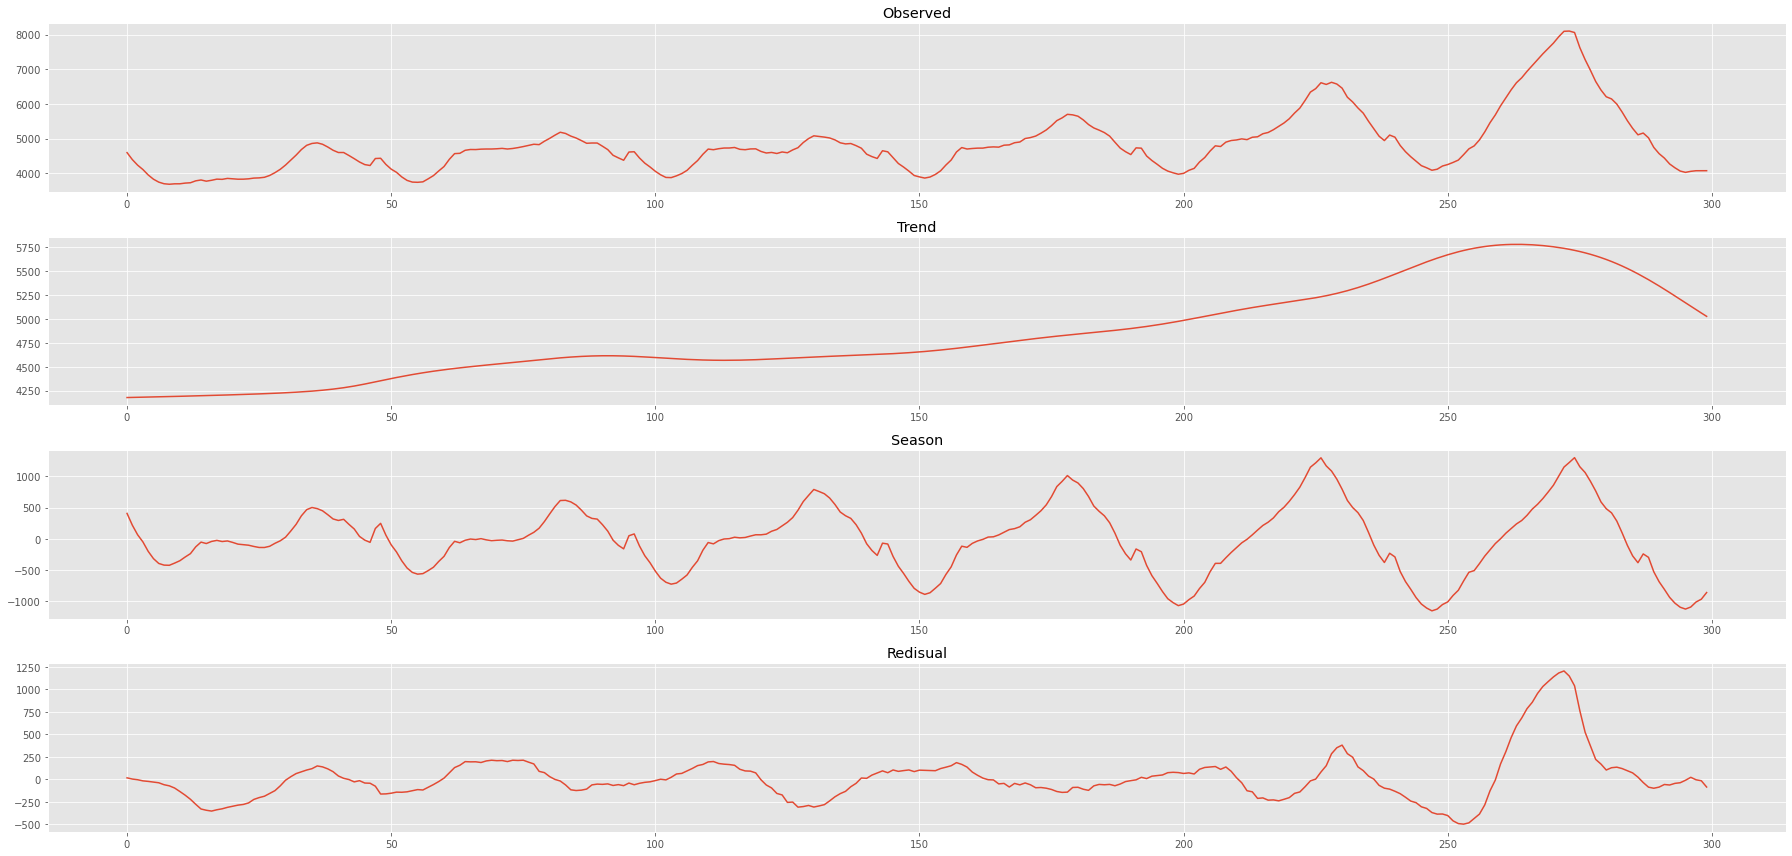

In [7]:
# Plot seasonal decompose
plot_seasonal_decompose(df_train.demand_vic, method='loess', end=300)

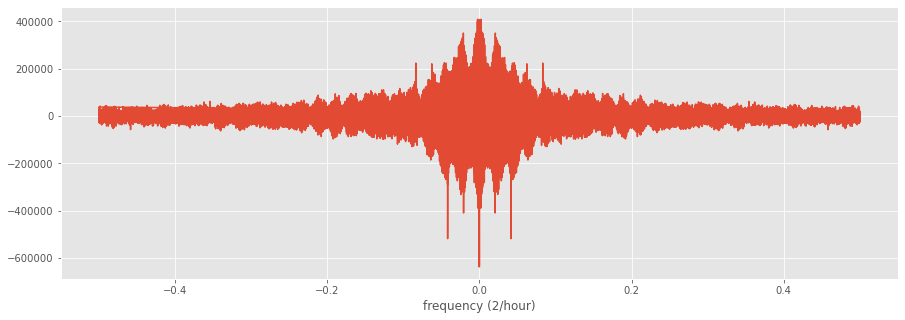

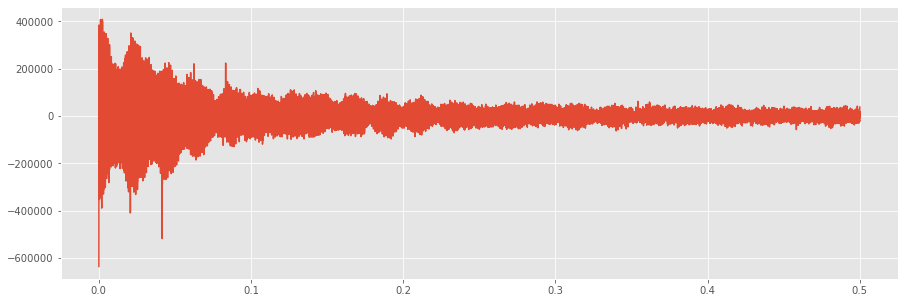

,rfft_y,rfft_freq,period_hours
0,4412456.87,0.00,inf
121,408540.96,0.00,869.55
59,407935.88,0.00,1783.32
124,399982.32,0.00,848.52
62,387808.55,0.00,1697.03


In [8]:
# Plot fft
fft = np.fft.fft(df_train.spot_price_vic)
fftfreq = np.fft.fftfreq(len(df_train))
plt.figure(figsize=(15,5))
plt.plot(fftfreq[1:], fft[1:])
plt.xlabel('frequency (2/hour)')
plt.show()

# Plot rfft
rfft = np.fft.rfft(df_train.spot_price_vic)
rfftfreq = np.fft.rfftfreq(len(df_train))
plt.figure(figsize=(15,5))
plt.plot(rfftfreq[1:], rfft[1:])
plt.show()

df_rfft = pd.DataFrame({'rfft_y': rfft, 'rfft_freq': rfftfreq})
df_rfft['period_hours'] = 2 / df_rfft.rfft_freq
df_rfft.sort_values('rfft_y')[::-1].head()

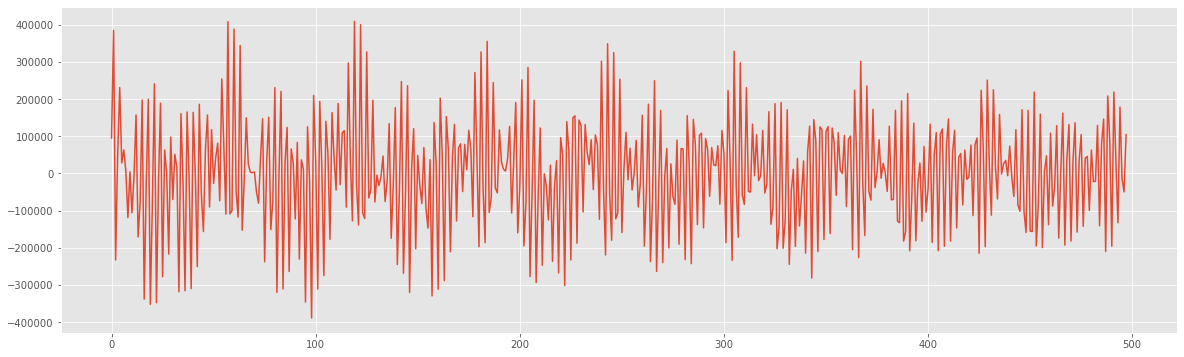

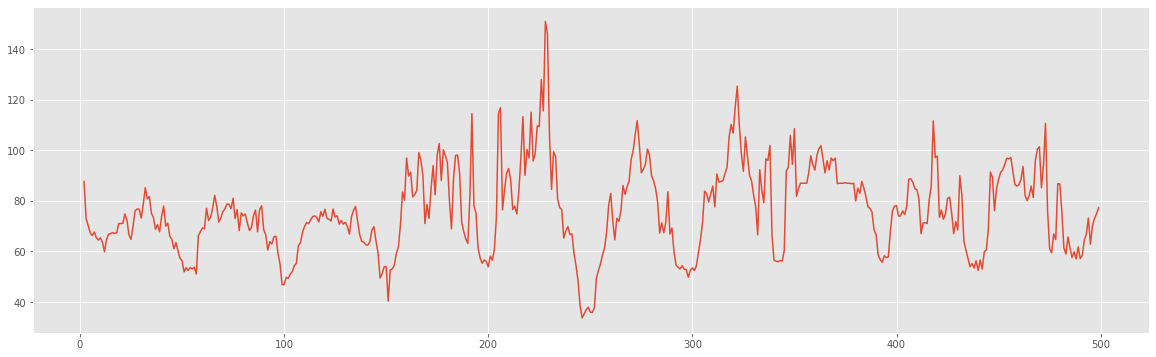

In [9]:
# Deeper insight
plt.figure(figsize=(20,6))
plt.plot(fft[2:500])
plt.figure(figsize=(20,6))
plt.plot(df_train.spot_price_vic[2:500])
plt.show()

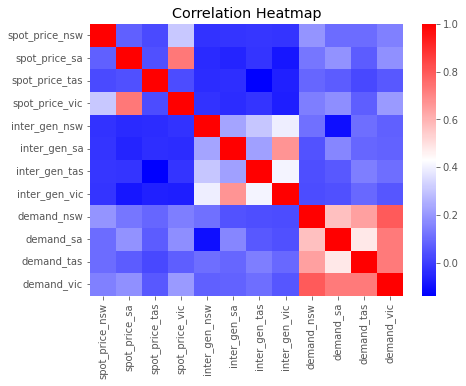

In [10]:
# Plot feature correlation
plt.figure(figsize=(7,5))
sns.heatmap(df.drop(columns=['period']).corr(), cmap="bwr")
plt.title('Correlation Heatmap')
plt.show()

## 3) Try fitting the SARIMAX model using:
1. **ALL** state intergen and demand
2. **ONE** state intergen and demand

In [16]:
df.columns # see what columns we have

Index(['spot_price_nsw', 'spot_price_sa', 'spot_price_tas', 'spot_price_vic',
       'inter_gen_nsw', 'inter_gen_sa', 'inter_gen_tas', 'inter_gen_vic',
       'demand_nsw', 'demand_sa', 'demand_tas', 'demand_vic', 'period'],
      dtype='object')

### 3.1) Method 1: Use all state intergen and demand as exogenous

In [41]:
iqr = df_train.spot_price_vic.quantile(0.75) - df_train.spot_price_vic.quantile(0.25)
lower = df_train.spot_price_vic.quantile(0.25) - 1.5 * iqr
upper = df_train.spot_price_vic.quantile(0.75) + 1.5 * iqr
y_train = df_train.spot_price_vic.clip(lower=lower, upper=upper)
y_test = df_cv.spot_price_vic

columns = ['inter_gen_nsw', 'inter_gen_sa', 'inter_gen_tas', 'inter_gen_vic',
           'demand_nsw', 'demand_sa', 'demand_tas', 'demand_vic']
X_train = df_train[columns]
X_test = df_cv[columns]

order = (1, 1, 1) # AR, I, MA
model = SARIMAX(endog=y_train,
                exog=X_train,
                order=order,
                measurement_error=True)

# fit the model
start = time()
model_fit = model.fit(disp=False)
end = time()
print('Model Fitting Time:', end - start, 'seconds\n')
print(model_fit.summary())

Model Fitting Time: 89.69211792945862 seconds

                               SARIMAX Results                                
Dep. Variable:         spot_price_vic   No. Observations:                52608
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -218184.555
Date:                Wed, 06 Oct 2021   AIC                         436393.110
Time:                        06:02:29   BIC                         436499.557
Sample:                    01-01-2018   HQIC                        436426.375
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
inter_gen_nsw            -0.0737      0.004    -18.381      0.000      -0.082      -0.066
inter_gen_sa             -0.0389      0.003    -12.

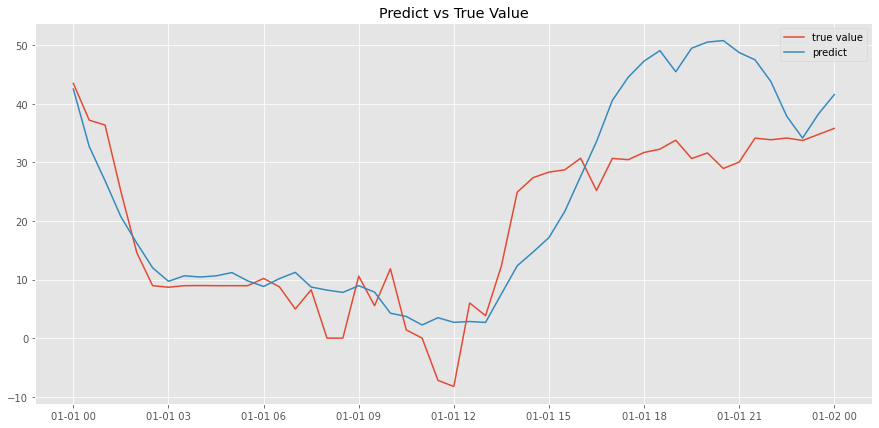

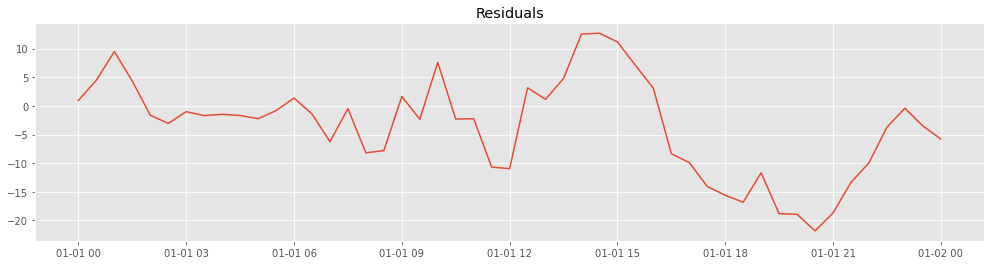

Root Mean Squared Error: 9.126424429995268


In [43]:
pred_start_date = y_test.index[0]
pred_end_date = y_test.index[-1]

predictions = model_fit.predict(exog=X_test, start=pred_start_date, end=pred_end_date)

start = 0
end = start + 49

residuals = y_test[start:end] - predictions[start:end]

plt.figure(figsize=(15,7))
plt.title('Predict vs True Value')
plt.plot(y_test[start:end], label='true value')
plt.plot(predictions[start:end], label='predict')
plt.legend()
plt.show()

plt.figure(figsize=(17, 4))
plt.title('Residuals')
plt.plot(residuals)
plt.show()

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

### 3.2) Method 2: Use ONLY one state intergen and demand as exogenous

In [38]:
iqr = df_train.spot_price_vic.quantile(0.75) - df.spot_price_vic.quantile(0.25)
lower = df_train.spot_price_vic.quantile(0.25) - 1.5 * iqr
upper = df_train.spot_price_vic.quantile(0.75) + 1.5 * iqr
y_train = df_train.spot_price_vic.clip(lower=lower, upper=upper)
y_test = df_cv.spot_price_vic
X_train = df_train[['inter_gen_vic', 'demand_vic']]
X_test = df_cv[['inter_gen_vic', 'demand_vic']]

order = (1, 1, 1) # AR, I, MA
model = SARIMAX(endog=y_train,
                exog=X_train,
                order=order)

# fit the model
start = time()
model_fit = model.fit(disp=False)
end = time()
print('Model Fitting Time:', end - start, 'seconds\n')
print(model_fit.summary())

Model Fitting Time: 36.29607796669006 seconds

                               SARIMAX Results                                
Dep. Variable:         spot_price_vic   No. Observations:                52608
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -220710.668
Date:                Wed, 06 Oct 2021   AIC                         441431.335
Time:                        05:59:47   BIC                         441475.688
Sample:                    01-01-2018   HQIC                        441445.196
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inter_gen_vic    -0.0979      0.002    -44.233      0.000      -0.102      -0.094
demand_vic        0.0290      0.000    138.992      0.000       0.029      

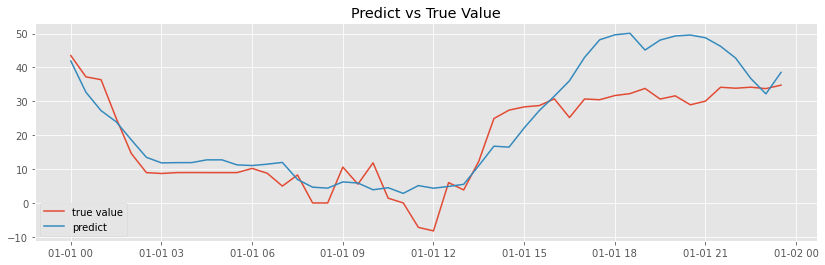

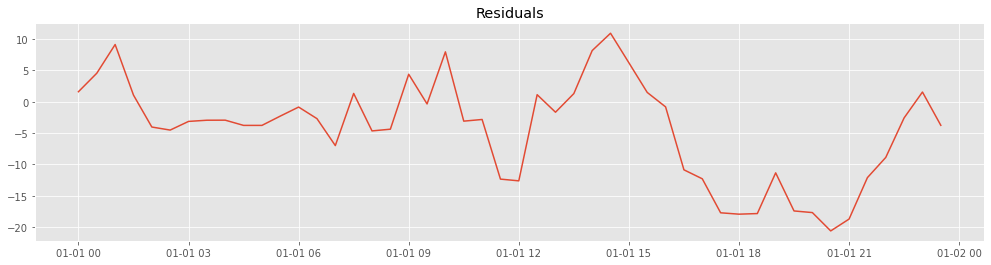

Root Mean Squared Error: 9.053242140754707


In [39]:
pred_start_date = y_test.index[0]
pred_end_date = y_test.index[-1]

predictions = model_fit.predict(exog=X_test, start=pred_start_date, end=pred_end_date)

start = 0
end = start + 48

residuals = y_test[start:end] - predictions[start:end]

plt.figure(figsize=(14, 4))
plt.title('Predict vs True Value')
plt.plot(y_test[start:end], label='true value')
plt.plot(predictions[start:end], label='predict')
plt.legend()
plt.show()

plt.figure(figsize=(17, 4))
plt.title('Residuals')
plt.plot(residuals)
plt.show()

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

### 3.3) Conclusion
Prefer using only one state as it will save a lot of time and yet its has smaller RMSE.

## 4) Method 1: Predict spot price 48 period ahead (using **known** demand)
- Assumptions:
   1. known demand
- Ideas: we predict t+1 to t+48 spot prices, and use t+1 to t+48 prices to predict t+48+1 to t+2*48 prices and so on.
- Caution: This will take you more than one hour to compute.

In [ ]:
df['predicted_spot_price_vic_1'] = np.nan
one_day = 48 # periods in one day
n = int(len(df_cv)/one_day) # number of period in one day

### 4.1) Predict CV period

In [ ]:
start = idx_cv_start 

for i in range(n):
    # we set lower and upper boundary so outliers won't affect our model too much
    # boundaries update on every looping
    iqr = df.spot_price_vic[:start].quantile(0.75) - df.spot_price_vic[:start].quantile(0.25)
    lower = df.spot_price_vic[:start].quantile(0.25) - 1.5 * iqr
    upper = df.spot_price_vic[:start].quantile(0.75) + 1.5 * iqr
    
    y_train = df.spot_price_vic[:start].clip(lower=lower, upper=upper)
    y_test = df.spot_price_vic[start:start+one_day]
    X_train = df[['inter_gen_vic', 'demand_vic']][:start]
    X_test = df[['inter_gen_vic', 'demand_vic']][start:start+one_day]

    order = (1, 1, 1) # AR, I, MA
    model = SARIMAX(endog=y_train,
                    exog=X_train,
                    order=order)
    
    model_fit = model.fit(disp=False)
    
    pred_start_date = y_test.index[0]
    pred_end_date = y_test.index[-1]

    predictions = model_fit.predict(exog=X_test, start=pred_start_date, end=pred_end_date)
    
    # save predictions
    df.predicted_spot_price_vic_1[start:start+one_day] = predictions
    
    start += one_day

# output predictions to csv
vic_spot_price_cv_sarimax_48period = df[['spot_price_vic', 'predicted_spot_price_vic_1']][idx_cv_start:idx_cv_start+n*one_day].reset_index()
vic_spot_price_cv_sarimax_48period.columns = ['time', 'spot_price', 'predicted_spot_price']
vic_spot_price_cv_sarimax_48period.to_csv('predictions/vic_spot_price_cv_sarimax_48period.csv', index=False, header=True)

### 4.2) Predict Test period

In [102]:
start = idx_test_start 

for i in range(n):
    # we set lower and upper boundary so outliers won't affect our model too much
    # boundaries update on every looping
    iqr = df.spot_price_vic[:start].quantile(0.75) - df.spot_price_vic[:start].quantile(0.25)
    lower = df.spot_price_vic[:start].quantile(0.25) - 1.5 * iqr
    upper = df.spot_price_vic[:start].quantile(0.75) + 1.5 * iqr
    
    y_train = df.spot_price_vic[:start].clip(lower=lower, upper=upper)
    y_test = df.spot_price_vic[start:start+one_day]
    X_train = df[['inter_gen_vic', 'demand_vic']][:start]
    X_test = df[['inter_gen_vic', 'demand_vic']][start:start+one_day]
    
    order = (1, 1, 1) # AR, I, MA
    model = SARIMAX(endog=y_train,
                    exog=X_train,
                    order=order)
    
    model_fit = model.fit(disp=False)
    
    pred_start_date = y_test.index[0]
    pred_end_date = y_test.index[-1]

    predictions = model_fit.predict(exog=X_test, start=pred_start_date, end=pred_end_date)
    
    # save predictions
    df['predicted_spot_price_vic_1'][start:start+one_day] = predictions
    
    start += one_day
    break

# output predictions to csv
vic_spot_price_test_sarimax_48period = df[['spot_price_vic', 'predicted_spot_price_vic_1']][idx_test_start:idx_test_start+n*one_day].reset_index()
vic_spot_price_test_sarimax_48period.columns = ['time', 'spot_price', 'predicted_spot_price']
vic_spot_price_test_sarimax_48period.to_csv('predictions/vic_spot_price_test_sarimax_48period.csv', index=False, header=True)

## 5) Method 2: Use **predicted** demand to predict spot price 48 period ahead
- Idea: Same ideas as the previous one but with **predicted** demand.  
- Caution: Again, this will take you more than one hour to compute.

### 5.1) Load predicted demand data

In [148]:
demand_cv_predicted = pd.read_csv('predictions/vic_demand_cv_rfr.csv')
demand_test_predicted = pd.read_csv('predictions/vic_demand_test_rfr.csv')
demand_cv_predicted.tail(3)

,time,demand_vic,predicted_demand_vic
8685,2021-06-30 22:30:00,5653,5747.55
8686,2021-06-30 23:00:00,5397,5561.54
8687,2021-06-30 23:30:00,5487,5568.57


In [149]:
df['predicted_demand_vic'] = np.nan
df['predicted_demand_vic'][:idx_cv_start] = df.demand_vic[:idx_cv_start] # fill with actual demand
df['predicted_demand_vic'][idx_cv_start:idx_test_start] = demand_cv_predicted.predicted_demand_vic
df['predicted_demand_vic'][idx_test_start:] = demand_test_predicted.predicted_demand_vic
df.tail(3)

,spot_price_nsw,spot_price_sa,spot_price_tas,spot_price_vic,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_nsw,demand_sa,demand_tas,demand_vic,period,predicted_demand_vic,predicted_spot_price_vic,predicted_spot_price_vic_1,predicted_spot_price_vic_2
time,,,,,,,,,,,,,,,,,
2021-08-11 22:30:00,55.27,52.01,20.91,54.29,156.25,240.22,166.32,330.72,8002,1735,1338,5450,46,5504.32,NaN,NaN,NaN
2021-08-11 23:00:00,51.44,48.29,13.68,49.25,150.55,228.38,165.11,320.81,7849,1654,1308,5269,47,5342.34,NaN,NaN,NaN
2021-08-11 23:30:00,54.42,49.82,11.29,51.37,146.67,242.53,167.19,296.36,7795,1571,1259,5332,48,5300.79,NaN,NaN,NaN


### 5.2) Predict CV period 

In [158]:
one_day = 48 # periods in one day
n = int(len(df_cv)/one_day) # number of period in one day
df['predicted_spot_price_vic_2'] = np.nan

In [159]:
one_day = 48 # periods in one day
n = int(len(df_cv)/one_day) # number of days in cv set
start = idx_cv_start 

for i in range(n):
    # we set lower and upper boundary so outliers won't affect our model too much
    # boundaries update on every looping
    iqr = df.spot_price_vic[:start].quantile(0.75) - df.spot_price_vic[:start].quantile(0.25)
    lower = df.spot_price_vic[:start].quantile(0.25) - 1.5 * iqr
    upper = df.spot_price_vic[:start].quantile(0.75) + 1.5 * iqr
    
    y_train = df.spot_price_vic[:start].clip(lower=lower, upper=upper)
    y_test = df.spot_price_vic[start:start+one_day]
    X_train = df[['inter_gen_vic', 'demand_vic']][:start]
    X_test = df[['inter_gen_vic', 'predicted_demand_vic']][start:start+one_day]

    order = (1, 1, 1) # AR, I, MA
    model = SARIMAX(endog=y_train,
                    exog=X_train,
                    order=order)
    
    model_fit = model.fit(disp=False)
    
    pred_start_date = y_test.index[0]
    pred_end_date = y_test.index[-1]

    predictions = model_fit.predict(exog=X_test, start=pred_start_date, end=pred_end_date)
    
    # save predictions
    df['predicted_spot_price_vic_2'][start:start+one_day] = predictions
    
    start += one_day

In [ ]:
# output predictions to csv
vic_spot_price_cv_predicted_demand_48period = df[['spot_price_vic', 'predicted_spot_price_vic_2']][idx_cv_start:idx_cv_start+n*one_day].reset_index()
vic_spot_price_cv_predicted_demand_48period.columns = ['time', 'spot_price', 'predicted_spot_price']
vic_spot_price_cv_predicted_demand_48period.to_csv('predictions/vic_spot_price_cv_predicted_demand_48period.csv', index=False, header=True)

### 5.3) Predict Test period

In [160]:
one_day = 48 # periods in one day
n = int(len(df_test)/one_day) # number of days in cv set
start = idx_test_start 

In [161]:
for i in range(n):
    # we set lower and upper boundary so outliers won't affect our model too much
    # boundaries update on every looping
    iqr = df.spot_price_vic[:start].quantile(0.75) - df.spot_price_vic[:start].quantile(0.25)
    lower = df.spot_price_vic[:start].quantile(0.25) - 1.5 * iqr
    upper = df.spot_price_vic[:start].quantile(0.75) + 1.5 * iqr
    
    y_train = df.spot_price_vic[:start].clip(lower=lower, upper=upper)
    y_test = df.spot_price_vic[start:start+one_day]
    X_train = df[['inter_gen_vic', 'demand_vic']][:start]
    X_test = df[['inter_gen_vic', 'predicted_demand_vic']][start:start+one_day]

    order = (1, 1, 1) # AR, I, MA
    model = SARIMAX(endog=y_train,
                    exog=X_train,
                    order=order)
    
    model_fit = model.fit(disp=False)
    
    pred_start_date = y_test.index[0]
    pred_end_date = y_test.index[-1]

    predictions = model_fit.predict(exog=X_test, start=pred_start_date, end=pred_end_date)
    
    # save predictions
    df['predicted_spot_price_vic_2'][start:start+one_day] = predictions
    
    start += one_day


In [ ]:
# output predictions to csv
vic_spot_price_test_predicted_demand_48period = df[['spot_price_vic', 'predicted_spot_price_vic_2']][idx_test_start:idx_test_start+n*one_day].reset_index()
vic_spot_price_test_predicted_demand_48period.columns = ['time', 'spot_price', 'predicted_spot_price']
vic_spot_price_test_predicted_demand_48period.to_csv('predictions/vic_spot_price_test_predicted_demand_48period.csv', index=False, header=True)